## Evaluate similarity metrics for CT patterns

In [2]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import scipy
import random

from experiments.causal_trace import plot_trace_heatmap, plot_trace_heatmap_from_values, plot_normalized_trace_heatmap_from_values

In [3]:
query_file = "/cephyr/users/lovhag/Alvis/projects/rome/data/P19_gpt2_xl_preds.jsonl"
results1_subj_limit = 2314
results_folders = ["/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P19/causal_trace_pararel_1711765",
                   "/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P19/causal_trace_pararel_1815989"
                  ]

In [4]:
queries = pd.DataFrame()
with open(query_file) as f:
    for line in f:
        queries = queries.append(json.loads(line), ignore_index=True)
        
queries.head()

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,top10_tokens,top10_tokens_probs
0,Alexandra,0.024580,London,2.0,0.000011,3197.0,0.0,New,0.038592,Allan Peiper was born in,P19,Allan Peiper,{} was born in,"[ New, the, London, 18, Toronto, Montreal...","[0.03859247639775276, 0.03803418204188347, 0.0..."
1,Alexandra,0.029013,Canada,2.0,0.000011,3354.0,1.0,the,0.077758,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from,"[ New, the, London, 18, Toronto, Montreal...","[0.04142675921320915, 0.07775774598121643, 0.0..."
2,Alexandra,0.023173,Canada,2.0,0.000013,3389.0,2.0,the,0.079163,Allan Peiper was originally from,P19,Allan Peiper,{} was originally from,"[ New, the, London, 18, Toronto, Montreal...","[0.03634488210082054, 0.07916285842657089, 0.0..."
3,Alexandra,0.035623,Canada,2.0,0.000005,4780.0,3.0,the,0.154659,Allan Peiper is native to,P19,Allan Peiper,{} is native to,"[ New, the, London, 18, Toronto, Montreal...","[0.03823259472846985, 0.15465885400772095, 0.0..."
4,Alexandra,0.032304,Canada,1.0,0.000007,4640.0,4.0,the,0.132673,Allan Peiper was native to,P19,Allan Peiper,{} was native to,"[ New, the, London, 18, Toronto, Montreal...","[0.029023099690675735, 0.13267268240451813, 0...."


## Calculate distance values

In [5]:
def get_cos_dist(lama_scores, scores):
    lama_scores = np.nan_to_num(lama_scores/np.linalg.norm(lama_scores, axis=1)[:, np.newaxis])
    scores = np.nan_to_num(scores/np.linalg.norm(scores, axis=1)[:, np.newaxis])
    sim = np.multiply(lama_scores, scores).sum(axis=1)
    return 1-sum(sim)/len(sim)

In [6]:
import ot

def get_wasserstein(lama_scores, scores):
    return ot.sliced_wasserstein_distance(lama_scores, scores, n_projections=10000, seed=63)

def get_wasserstein_norm(lama_scores, scores):
    scores = scores/scores.sum()
    lama_scores = lama_scores/lama_scores.sum()
    return ot.sliced_wasserstein_distance(lama_scores, scores, n_projections=10000, seed=63)

def get_wasserstein_norm_min(lama_scores, scores):
    scores = (scores-scores.min())
    scores = scores/scores.sum()
    lama_scores = (lama_scores-lama_scores.min())
    lama_scores = lama_scores/lama_scores.sum()
    return ot.sliced_wasserstein_distance(lama_scores, scores, n_projections=10000, seed=63)

get_ws_dist = get_wasserstein_norm

In [7]:
def get_kl_div(lama_scores, scores):
    scores = get_normalized_scores(scores)
    lama_scores = get_normalized_scores(lama_scores)
    return sum(scipy.special.rel_entr(scores, lama_scores))
    
def get_normalized_scores(scores):
    delta = 0.000001
    scores = (scores.flatten()-scores.flatten().min()+delta)
    scores = scores/scores.sum()
    
    return scores

def get_kl_div_no_min(lama_scores, scores):
    scores = get_normalized_scores_no_min(scores)
    lama_scores = get_normalized_scores_no_min(lama_scores)
    return sum(scipy.special.rel_entr(scores, lama_scores))
    
def get_normalized_scores_no_min(scores):
    scores = scores.flatten()
    scores = scores/scores.sum()
    
    return scores

#get_kl_div = get_kl_div_no_min

In [8]:
def get_results_for_token_ix(results, token_ix, answer_for_token):
    results = dict(results)
    results["scores"] = results["scores"][:,:,token_ix]
    results["low_score"] = results["low_score"][token_ix]
    results["high_score"] = results["high_score"][token_ix]
    results["answer"] = answer_for_token #a bit hacky to get the answer as argument
    return results
    
def get_results_for_subject(results):
    # assumes that results already has been filtered by token_id
    results["scores"] = results["scores"][results["subject_range"][0]:results["subject_range"][1],:]
    results["input_tokens"] = results["input_tokens"][results["subject_range"][0]:results["subject_range"][1]]
    results["input_ids"] = results["input_ids"][results["subject_range"][0]:results["subject_range"][1]]
    results["subject_range"] = np.array([0,len(results["input_tokens"])])
    return results

In [9]:
annotated_data = pd.read_csv("/cephyr/users/lovhag/Alvis/projects/rome/data/similarity/P19_annotated_val.csv")

Run similarity metrics

In [10]:
dist_results = {"cos_dist_ex1": [], 
                "cos_dist_ex2": [],
                "ws_dist_ex1": [],
                "ws_dist_ex2": [],
                "kl_dist_ex1": [],
                "kl_dist_ex2": []
               }

for ix, row in annotated_data.iterrows():
    if row.token_type == "any":
        token_ix = 0
        answer = queries.loc[row.lama_ix]["top10_tokens"][token_ix]
    elif row.token_type == "candidate":
        answer = queries.loc[row.lama_ix]["candidate_prediction"]
        token_ix = queries.loc[row.lama_ix]["top10_tokens"].index(answer)
        
    if row.lama_ix < results1_subj_limit:
        results_folder = results_folders[0]
    else:
        results_folder = results_folders[1]
    results_lama = np.load(os.path.join(results_folder, f"cases/{row.lama_ix}_any_mlp.npz"), allow_pickle=True)
    
    cos_dists = []
    ws_dists = []
    kl_dists = []
    for ix, sample_ix in enumerate([row.sample_ix_1, row.sample_ix_2]):
        proc_results_lama = get_results_for_token_ix(results_lama, token_ix, answer)
        proc_results_lama = get_results_for_subject(proc_results_lama)

        if sample_ix < results1_subj_limit:
            results_folder = results_folders[0]
        else:
            results_folder = results_folders[1]
            
        results = np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True)
        results = get_results_for_token_ix(results, token_ix, answer)
        results = get_results_for_subject(results)
        # run the function below to get this, otherwise just comment out this part
        cos_dists.append(get_cos_dist(proc_results_lama["scores"], results["scores"]))
        ws_dists.append(get_ws_dist(proc_results_lama["scores"], results["scores"]))
        kl_dists.append(get_kl_div(proc_results_lama["scores"], results["scores"])) #get_similarity_score(proc_results_lama, results) -- assume lower is better
    
    dist_results["cos_dist_ex1"].append(cos_dists[0])
    dist_results["cos_dist_ex2"].append(cos_dists[1])
    dist_results["ws_dist_ex1"].append(ws_dists[0])
    dist_results["ws_dist_ex2"].append(ws_dists[1])
    dist_results["kl_dist_ex1"].append(kl_dists[0])
    dist_results["kl_dist_ex2"].append(kl_dists[1])
    
annotated_data = pd.concat((annotated_data, pd.DataFrame(dist_results)), axis=1) 
annotated_data

,lama_ix,sample_ix_1,sample_ix_2,token_type,example_more_similar,cos_dist_ex1,cos_dist_ex2,ws_dist_ex1,ws_dist_ex2,kl_dist_ex1,kl_dist_ex2
0,294,295,297,any,1,0.002130,0.001774,0.000308,0.000281,0.050748,0.040376
1,4844,4845,4848,candidate,1,0.003200,0.132404,0.000851,0.004766,0.060397,0.290497
2,4529,4531,4534,candidate,1,0.009125,0.117249,0.000689,0.002602,0.071617,0.397253
3,2366,2370,2371,any,1,0.004034,0.033007,0.000504,0.001433,0.045685,0.333132
4,2366,2370,2371,candidate,1,0.031997,0.064715,0.002016,0.001884,0.083182,0.428244
...,...,...,...,...,...,...,...,...,...,...,...
194,651,652,653,candidate,3,0.004620,0.002150,0.000932,0.000657,0.006629,0.004034
195,1225,1231,1229,any,2,0.001702,0.001162,0.000129,0.000120,0.047190,0.019263
196,1225,1231,1229,candidate,2,0.018866,0.005493,0.000426,0.000245,0.058345,0.029997
197,266,267,272,any,2,0.000770,0.001332,0.000116,0.000139,0.029156,0.058912


## Compare distance values to annotations

In [11]:
acc_data = annotated_data.copy()
acc_data.head()

,lama_ix,sample_ix_1,sample_ix_2,token_type,example_more_similar,cos_dist_ex1,cos_dist_ex2,ws_dist_ex1,ws_dist_ex2,kl_dist_ex1,kl_dist_ex2
0,294,295,297,any,1,0.002130,0.001774,0.000308,0.000281,0.050748,0.040376
1,4844,4845,4848,candidate,1,0.003200,0.132404,0.000851,0.004766,0.060397,0.290497
2,4529,4531,4534,candidate,1,0.009125,0.117249,0.000689,0.002602,0.071617,0.397253
3,2366,2370,2371,any,1,0.004034,0.033007,0.000504,0.001433,0.045685,0.333132
4,2366,2370,2371,candidate,1,0.031997,0.064715,0.002016,0.001884,0.083182,0.428244


In [12]:
cos_dist_mean = 0.0155
ws_dist_mean = 0.0011
kl_dist_mean = 0.0728

def get_dist_accuracy(dist_1, dist_2, label, mean_dist):
    if label == 1:
        return int(dist_1<dist_2)
    elif label == 2:
        return int(dist_1>dist_2)
    elif label == 0:
        return int(dist_1>mean_dist and dist_2>mean_dist)
    elif label == 3:
        return int(abs(np.log10(dist_1)-np.log10(dist_2))<0.5)
    else:
        raise Exception("Annotated score not valid.")

In [13]:
acc_data["cos_dist_score"] = acc_data.apply(lambda row: get_dist_accuracy(row.cos_dist_ex1, row.cos_dist_ex2, row.example_more_similar, cos_dist_mean), axis=1)
acc_data["ws_dist_score"] = acc_data.apply(lambda row: get_dist_accuracy(row.ws_dist_ex1, row.ws_dist_ex2, row.example_more_similar, ws_dist_mean), axis=1)
acc_data["kl_dist_score"] = acc_data.apply(lambda row: get_dist_accuracy(row.kl_dist_ex1, row.kl_dist_ex2, row.example_more_similar, kl_dist_mean), axis=1)
acc_data.head()

,lama_ix,sample_ix_1,sample_ix_2,token_type,example_more_similar,cos_dist_ex1,cos_dist_ex2,ws_dist_ex1,ws_dist_ex2,kl_dist_ex1,kl_dist_ex2,cos_dist_score,ws_dist_score,kl_dist_score
0,294,295,297,any,1,0.002130,0.001774,0.000308,0.000281,0.050748,0.040376,0,0,0
1,4844,4845,4848,candidate,1,0.003200,0.132404,0.000851,0.004766,0.060397,0.290497,1,1,1
2,4529,4531,4534,candidate,1,0.009125,0.117249,0.000689,0.002602,0.071617,0.397253,1,1,1
3,2366,2370,2371,any,1,0.004034,0.033007,0.000504,0.001433,0.045685,0.333132,1,1,1
4,2366,2370,2371,candidate,1,0.031997,0.064715,0.002016,0.001884,0.083182,0.428244,1,0,1


In [14]:
acc_data[["token_type", "cos_dist_score", "ws_dist_score", "kl_dist_score"]].groupby("token_type").mean()

,cos_dist_score,ws_dist_score,kl_dist_score
token_type,,,
any,0.562500,0.552083,0.614583
candidate,0.864078,0.893204,0.883495


In [37]:
tmp_data = acc_data.copy()
tmp_data["example_more_similar"] = tmp_data.example_more_similar.replace([1,2], "1 or 2")
tmp_data[["example_more_similar", "token_type", "cos_dist_score", "ws_dist_score", "kl_dist_score"]].groupby(["token_type", "example_more_similar"]).agg({"cos_dist_score": ["mean"], "ws_dist_score": ["mean"], "kl_dist_score": ["mean", "count"]}) #.agg(["mean", "std"])

cos_dist_score ws_dist_score kl_dist_score  \
                                          mean          mean          mean   
token_type example_more_similar                                              
any        0                          0.071429      0.071429      0.357143   
           3                          0.787879      0.878788      0.757576   
           1 or 2                     0.742857      0.628571      0.685714   
candidate  0                          0.400000      0.400000      0.800000   
           3                          0.809524      0.928571      0.880952   
           1 or 2                     0.946429      0.910714      0.892857   

                                       
                                count  
token_type example_more_similar        
any        0                       28  
           3                       33  
           1 or 2                  35  
candidate  0                        5  
           3                       42  
           1 or 2                  56

### Error cases

In [16]:
tmp_data = acc_data[acc_data.example_more_similar.isin([1,2])].copy()
cos_dist_error_ix = set(tmp_data[tmp_data.cos_dist_score==0].index)
ws_dist_error_ix = set(tmp_data[tmp_data.ws_dist_score==0].index)
kl_dist_error_ix = set(tmp_data[tmp_data.kl_dist_score==0].index)

common_error_ix = (cos_dist_error_ix.intersection(ws_dist_error_ix).union(
    cos_dist_error_ix.intersection(kl_dist_error_ix).union(
        ws_dist_error_ix.intersection(kl_dist_error_ix)))
                  )
print(f"There are {len(common_error_ix)} common error cases.")
print(f"Total number of samples is {len(tmp_data)}.")

There are 14 common error cases.
Total number of samples is 91.


In [17]:
len(cos_dist_error_ix)

12

In [18]:
len(ws_dist_error_ix)

18

In [19]:
len(kl_dist_error_ix)

17

In [20]:
common_error_ix

{0, 8, 39, 52, 68, 69, 80, 108, 118, 125, 132, 143, 152, 197}

In [21]:
cos_dist_error_ix-common_error_ix

set()

In [22]:
ws_dist_error_ix-common_error_ix

{4, 12, 24, 90, 119}

In [23]:
kl_dist_error_ix-common_error_ix

{59, 130, 168, 190}

## Plot error cases

In [24]:
def plot_trace_heatmap_from_values(differences, low_score, high_score, answer, kind, window, labels, ax,
                                   savepdf, title, xlabel, modelname):
    with plt.rc_context():
        #fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
            vmax=high_score
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels, fontsize=8)
        cb = plt.colorbar(h, ax=ax)
        cb.ax.tick_params(labelsize=8)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=8)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        #else:
        #    plt.show()
            
def plot_trace_heatmap(result, ax, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    high_score = None #result["high_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    plot_trace_heatmap_from_values(differences, low_score, high_score, answer, kind, window, labels, ax,
                                   savepdf, title, xlabel, modelname)
 

SAMPLE 4 - Example 1 more similar
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) cos dist: 0.0320✅, ws dist: 0.00202❌, kl dist: 0.0832✅
---------------------------------------------------------------------------------------------------------


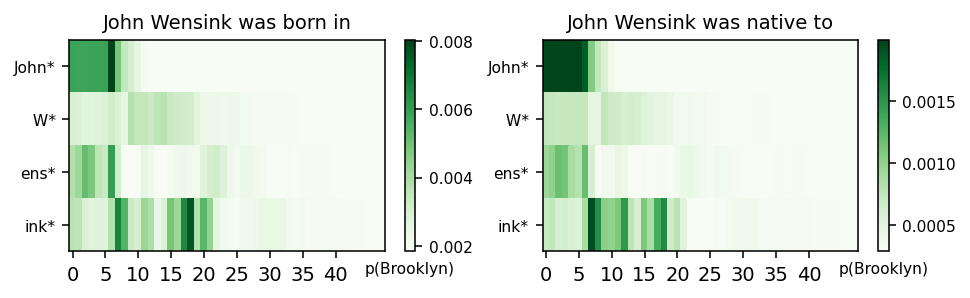

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) cos dist: 0.0647✅, ws dist: 0.00188❌, kl dist: 0.4282✅
---------------------------------------------------------------------------------------------------------


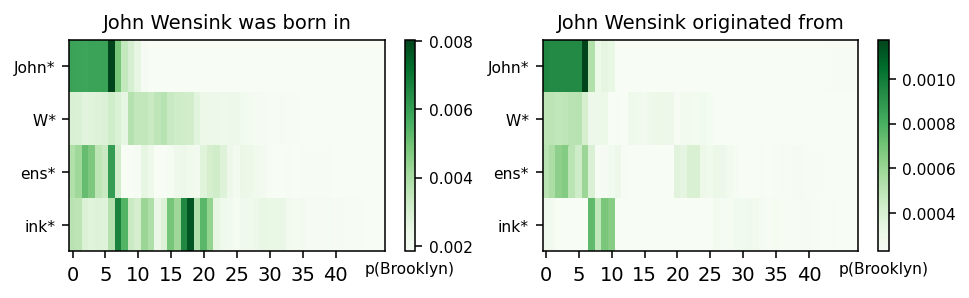

In [25]:
ix = 4
row = acc_data.loc[ix]
print("=========================================================================================================")
print(f"SAMPLE {ix} - Example {row.example_more_similar} more similar")
print("=========================================================================================================")

if row.token_type == "any":
    token_ix = 0
    answer = queries.loc[row.lama_ix]["top10_tokens"][token_ix]
elif row.token_type == "candidate":
    answer = queries.loc[row.lama_ix]["candidate_prediction"]
    token_ix = queries.loc[row.lama_ix]["top10_tokens"].index(answer)

if row.lama_ix < results1_subj_limit:
    results_folder = results_folders[0]
else:
    results_folder = results_folders[1]
results_lama = np.load(os.path.join(results_folder, f"cases/{row.lama_ix}_any_mlp.npz"), allow_pickle=True)

for ix, sample_ix in enumerate([row.sample_ix_1, row.sample_ix_2]):
    cos_correct = "✅" if row.cos_dist_score==1 else "❌"
    cos_str = f"cos_dist_ex{ix+1}"
    ws_correct = "✅" if row.ws_dist_score==1 else "❌"
    ws_str = f"ws_dist_ex{ix+1}"
    kl_correct = "✅" if row.kl_dist_score==1 else "❌"
    kl_str = f"kl_dist_ex{ix+1}"
    print("---------------------------------------------------------------------------------------------------------")
    print(f"Example {ix+1} (top {row.token_type} token) cos dist: {row[cos_str]:.4f}{cos_correct}, ws dist: {row[ws_str]:.5f}{ws_correct}, kl dist: {row[kl_str]:.4f}{kl_correct}")
    print("---------------------------------------------------------------------------------------------------------")

    proc_results_lama = get_results_for_token_ix(results_lama, token_ix, answer)
    proc_results_lama = get_results_for_subject(proc_results_lama)
    
    if sample_ix < results1_subj_limit:
        results_folder = results_folders[0]
    else:
        results_folder = results_folders[1]
    results = np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True)
    results = get_results_for_token_ix(results, token_ix, answer)
    results = get_results_for_subject(results)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
    plot_trace_heatmap(proc_results_lama, axs[0])
    axs[0].set_title(queries.iloc[row.lama_ix].prompt)
    axs[0].title.set_size(10)
    plot_trace_heatmap(results, axs[1])
    axs[1].set_title(queries.iloc[sample_ix].prompt)
    axs[1].title.set_size(10)
    plt.show()

## Further investigations

### Histograms

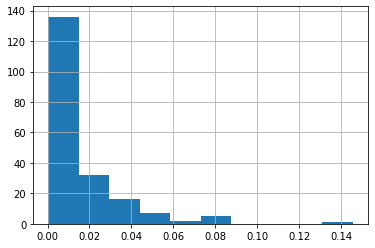

In [26]:
annotated_data.cos_dist_ex1.hist()
plt.show()

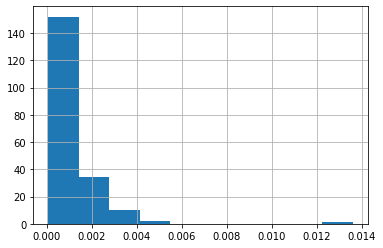

In [27]:
annotated_data.ws_dist_ex1.hist()
plt.show()

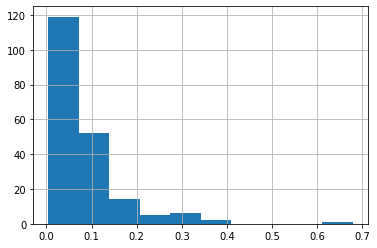

In [28]:
annotated_data.kl_dist_ex1.hist()
plt.show()

### Score correlations

In [29]:
annotated_data[["cos_dist_ex1", "ws_dist_ex1", "kl_dist_ex1"]].corr()

,cos_dist_ex1,ws_dist_ex1,kl_dist_ex1
cos_dist_ex1,1.000000,0.831083,0.659075
ws_dist_ex1,0.831083,1.000000,0.647244
kl_dist_ex1,0.659075,0.647244,1.000000


In [30]:
annotated_data[["cos_dist_ex2", "ws_dist_ex2", "kl_dist_ex2"]].corr()

,cos_dist_ex2,ws_dist_ex2,kl_dist_ex2
cos_dist_ex2,1.000000,0.871628,0.678844
ws_dist_ex2,0.871628,1.000000,0.681101
kl_dist_ex2,0.678844,0.681101,1.000000


### Correlation with annotations

Get distance differences for pairs.

In [31]:
dist_dict = {"cos": ["cos_dist_ex1", "cos_dist_ex2"], 
             "ws": ["ws_dist_ex1", "ws_dist_ex2"], 
             "kl": ["kl_dist_ex1", "kl_dist_ex2"]
            }
data = annotated_data.copy()
for key, value in dist_dict.items():
    data[f"{key}_dist_diff"] = data[value[0]]-data[value[1]]
data

,lama_ix,sample_ix_1,sample_ix_2,token_type,example_more_similar,cos_dist_ex1,cos_dist_ex2,ws_dist_ex1,ws_dist_ex2,kl_dist_ex1,kl_dist_ex2,cos_dist_diff,ws_dist_diff,kl_dist_diff
0,294,295,297,any,1,0.002130,0.001774,0.000308,0.000281,0.050748,0.040376,0.000356,0.000027,0.010372
1,4844,4845,4848,candidate,1,0.003200,0.132404,0.000851,0.004766,0.060397,0.290497,-0.129204,-0.003916,-0.230100
2,4529,4531,4534,candidate,1,0.009125,0.117249,0.000689,0.002602,0.071617,0.397253,-0.108123,-0.001912,-0.325636
3,2366,2370,2371,any,1,0.004034,0.033007,0.000504,0.001433,0.045685,0.333132,-0.028974,-0.000929,-0.287448
4,2366,2370,2371,candidate,1,0.031997,0.064715,0.002016,0.001884,0.083182,0.428244,-0.032718,0.000131,-0.345061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,651,652,653,candidate,3,0.004620,0.002150,0.000932,0.000657,0.006629,0.004034,0.002470,0.000275,0.002595
195,1225,1231,1229,any,2,0.001702,0.001162,0.000129,0.000120,0.047190,0.019263,0.000540,0.000010,0.027927
196,1225,1231,1229,candidate,2,0.018866,0.005493,0.000426,0.000245,0.058345,0.029997,0.013373,0.000181,0.028348
197,266,267,272,any,2,0.000770,0.001332,0.000116,0.000139,0.029156,0.058912,-0.000562,-0.000023,-0.029756


Get correlations for 1 and 2 annotations.

In [32]:
sub_data = data[data.example_more_similar.isin([1, 2])].copy()
sub_data["ex1_more_similar"] = sub_data["example_more_similar"].replace(2, 0)
sub_data[sub_data.token_type=="candidate"][[f"{key}_dist_diff" for key in dist_dict.keys()]+["ex1_more_similar"]].corr()

,cos_dist_diff,ws_dist_diff,kl_dist_diff,ex1_more_similar
cos_dist_diff,1.000000,0.870553,0.839077,-0.581166
ws_dist_diff,0.870553,1.000000,0.756403,-0.609645
kl_dist_diff,0.839077,0.756403,1.000000,-0.620430
ex1_more_similar,-0.581166,-0.609645,-0.620430,1.000000


In [33]:
sub_data[sub_data.token_type=="any"][[f"{key}_dist_diff" for key in dist_dict.keys()]+["ex1_more_similar"]].corr()

,cos_dist_diff,ws_dist_diff,kl_dist_diff,ex1_more_similar
cos_dist_diff,1.000000,0.849560,0.530276,-0.385561
ws_dist_diff,0.849560,1.000000,0.382248,-0.278225
kl_dist_diff,0.530276,0.382248,1.000000,-0.494252
ex1_more_similar,-0.385561,-0.278225,-0.494252,1.000000


Also check cases for which the samples are both very dissimilar, or equally similar/dissimilar to LAMA

In [34]:
data.example_more_similar.value_counts()

3    75
1    46
2    45
0    33
Name: example_more_similar, dtype: int64

In [35]:
data.groupby(["token_type", "example_more_similar"]).agg({"cos_dist_diff": ["mean","std"], 
                                                          "ws_dist_diff": ["mean","std"], 
                                                          "kl_dist_diff": ["mean","std"]})

cos_dist_diff           ws_dist_diff  \
                                         mean       std         mean   
token_type example_more_similar                                        
any        0                         0.001685  0.010378     0.000083   
           1                        -0.005340  0.008743    -0.000223   
           2                         0.004270  0.013839     0.000125   
           3                         0.000658  0.019814     0.000053   
candidate  0                        -0.005863  0.016121    -0.000252   
           1                        -0.025155  0.029951    -0.000867   
           2                         0.017067  0.030114     0.000860   
           3                         0.002017  0.015413     0.000130   

                                          kl_dist_diff            
                                      std         mean       std  
token_type example_more_similar                                   
any        0                     0.000430    -0.004456  0.092568  
           1                     0.000564    -0.100163  0.137303  
           2                     0.000657     0.015121  0.064262  
           3                     0.000837     0.007448  0.067491  
candidate  0                     0.000737    -0.013709  0.098230  
           1                     0.000968    -0.108398  0.113207  
           2                     0.001313     0.051452  0.088775  
           3                     0.000703    -0.003404  0.062167

In [36]:
data.groupby(["token_type", "example_more_similar"]).agg({"cos_dist_ex1": ["mean","std"], 
                                                          "ws_dist_ex1": ["mean","std"],
                                                          "kl_dist_ex1": ["mean","std"]})

cos_dist_ex1           ws_dist_ex1            \
                                        mean       std        mean       std   
token_type example_more_similar                                                
any        0                        0.008994  0.018775    0.000625  0.000759   
           1                        0.005788  0.005638    0.000564  0.000288   
           2                        0.010788  0.013884    0.000731  0.000483   
           3                        0.012596  0.017668    0.000923  0.000975   
candidate  0                        0.023394  0.014132    0.001550  0.001341   
           1                        0.015662  0.027049    0.001413  0.002411   
           2                        0.027893  0.019663    0.001892  0.001164   
           3                        0.016760  0.017751    0.001304  0.000747   

                                kl_dist_ex1            
                                       mean       std  
token_type example_more_similar                        
any        0                       0.095377  0.085348  
           1                       0.062074  0.060396  
           2                       0.066926  0.061778  
           3                       0.059450  0.064194  
candidate  0                       0.211436  0.132640  
           1                       0.084190  0.128734  
           2                       0.106442  0.072155  
           3                       0.072492  0.058182